# Momentum Trading

The Momentum Trading (called MT afterward) is commonly used as indicator for trading trends. It uses a simple base which is :

<h4><center><i>A body in motion tends to stay in motion. (Isaac Newton)</i></center></h4>

As a result, the principle is quite simple. With N stocks, we place our portfolio on the action having the best performance is the last K timesteps (can be 15 minutes, 1 week, 2 month, a year) for a duration of 1 timestep. After this duration, we start again to take the stock having the best performance in the last K timesteps and so on forever.

It can be represented as follow :

<img src="momentum_good.png"/>

There is several papers about this method and also some variants (like the Dual Momentum). All of them shows very promessing results but this seems too good to be true. This project will contain multiple Notebooks and we will try to simulate and see if this method is really as good as papers says. We will also try to improve this method using tools from Machine Learning.

In [3]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

## Create our dataset

The first thing we need here is to get multiple stocks to retreive the historical data for each of them. As I need a free API, I decided to use <a href="https://iextrading.com/">iextrading</a> which is free to use, free to share and having a python library to simplify the work.

So first let's query the list of Stocks available

### Find Stocks

This is done with requests as there is page having all of them in json format.

In [2]:
# import requests

In [3]:
# r = requests.get("https://api.iextrading.com/1.0/ref-data/symbols")
# print("Status :", r.status_code)
# print("Header :", r.headers['content-type'])
# print("Encoding :", r.encoding)
# result = r.json()
# print("Number of results :", len(result))
# symbols = pd.DataFrame(result)
# symbols.to_csv("F:/data/trading/symbols.csv", index=False)

In [3]:
symbols = pd.read_csv("F:/data/trading/symbols.csv")
symbols.head()

,date,iexId,isEnabled,name,symbol,type
0,2018-11-02,2,True,Agilent Technologies Inc.,A,cs
1,2018-11-02,12042,True,Alcoa Corporation,AA,cs
2,2018-11-02,14924,True,Perth Mint Physical Gold,AAAU,NaN
3,2018-11-02,7653,True,Altaba Inc.,AABA,cs
4,2018-11-02,9169,True,AAC Holdings Inc.,AAC,cs


In [4]:
symbols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8758 entries, 0 to 8757
Data columns (total 6 columns):
date         8758 non-null object
iexId        8758 non-null int64
isEnabled    8758 non-null bool
name         8635 non-null object
symbol       8758 non-null object
type         6975 non-null object
dtypes: bool(1), int64(1), object(4)
memory usage: 350.7+ KB


On this list of 8758 stocks, we want to keep only ETFs. This is not mandatory but at least in France there is less taxes to buy them (around 0.25% instead of 2%). To get them, I only kept the one having "ETF" in their name.

In [5]:
symbols["is_ETF"] = symbols["name"].str.contains("ETF")
symbols["is_ETF"].value_counts()

False    8361
True      274
Name: is_ETF, dtype: int64

We have now 274 ETFs available so we will extract the symbols to querty the history

In [8]:
symbols[symbols["is_ETF"] == True].head()

,date,iexId,isEnabled,name,symbol,type,is_ETF
76,2018-11-02,13895,True,AdvisorShares Vice ETF,ACT,NaN,True
217,2018-11-02,199,True,iShares Asia 50 ETF,AIA,et,True
231,2018-11-02,14539,True,Global X Future Analytics Tech ETF,AIQ,NaN,True
311,2018-11-02,10294,True,Global X SuperDividend Alternatives ETF,ALTY,NaN,True
327,2018-11-02,13234,True,iShares Russell 1000 Pure U.S. Revenue ETF,AMCA,NaN,True


In [8]:
wanted_symbols = symbols[symbols["is_ETF"] == True]["symbol"].tolist()

### Query historical data

To get the history, we can use directly the library "iexfinance" which is quite simple and directly provide the daily results as a dataframe. With free account, we can query only daily results and an history of 5 years maximum.

In [10]:
# from iexfinance import get_historical_data
# from datetime import datetime

In [11]:
# start = datetime(2013, 11, 2)
# end = datetime(2018, 11, 2)

# passe = True
# for each in wanted_symbols:
#     if each != "PRN" and passe:
#         print(each, " done")
#         continue
#     if each == "PRN":
#         print(each, " done")
#         passe = False
#         continue
        
#     try:
#         df = get_historical_data(each, start=start, end=end, output_format='pandas')
#         df.to_csv("F:/data/trading/extracts/{}.csv".format(each))
#         print(each, " done")
#     except:
#         print("Error with", each)

During the query, there were issue with  : 
- PACA
- PRN

They are just skipped so we only have 172 ETFs now. 

Let's now merge all  dataframe in a single gloabl one.

In [12]:
# import glob
# import os

# list_df = []
# for file in glob.glob("F:/data/trading/extracts/*.csv"):
#     symbol = os.path.basename(file)[:-4]
#     sub_df = pd.read_csv(file, index_col = 0)
#     sub_df = sub_df.reset_index()
#     sub_df["symbol"] = symbol
#     list_df.append(sub_df)

In [13]:
# final_df = pd.concat(list_df)
# final_df = final_df.reset_index(drop=True)
# final_df.to_csv("F:/data/trading/history.csv")

That's it, we can now start the exploration

# Exploration

In [14]:
df = pd.read_csv("F:/data/trading/history.csv", index_col=0)

In [15]:
df.head()

,date,open,high,low,close,volume,symbol
0,2017-12-13,25.1561,25.2360,25.0563,25.1262,40255,ACT
1,2017-12-14,26.2043,26.2043,24.9365,24.9665,74075,ACT
2,2017-12-15,25.7850,25.7850,25.0064,25.1367,74254,ACT
3,2017-12-18,25.8349,26.3270,25.3458,25.3458,29223,ACT
4,2017-12-19,25.8948,27.2026,25.3566,25.4855,31291,ACT


In [16]:
df.tail()

,date,open,high,low,close,volume,symbol
192106,2018-10-26,26.8900,26.9600,26.8900,26.9580,300,YLDE
192107,2018-10-29,NaN,NaN,NaN,26.9580,82,YLDE
192108,2018-10-30,27.1500,27.1500,27.1500,27.1500,2513,YLDE
192109,2018-11-01,27.6999,27.7838,27.6320,27.7838,1205,YLDE
192110,2018-11-02,27.8400,27.8400,27.6231,27.6231,2440,YLDE


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192111 entries, 0 to 192110
Data columns (total 7 columns):
date      192111 non-null object
open      185309 non-null float64
high      185312 non-null float64
low       185312 non-null float64
close     192111 non-null float64
volume    192111 non-null int64
symbol    192111 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 11.7+ MB


### Cleanup missing values

We can see that there is few missing values only on open/high/low. If we look at worst case, the stock value looks like

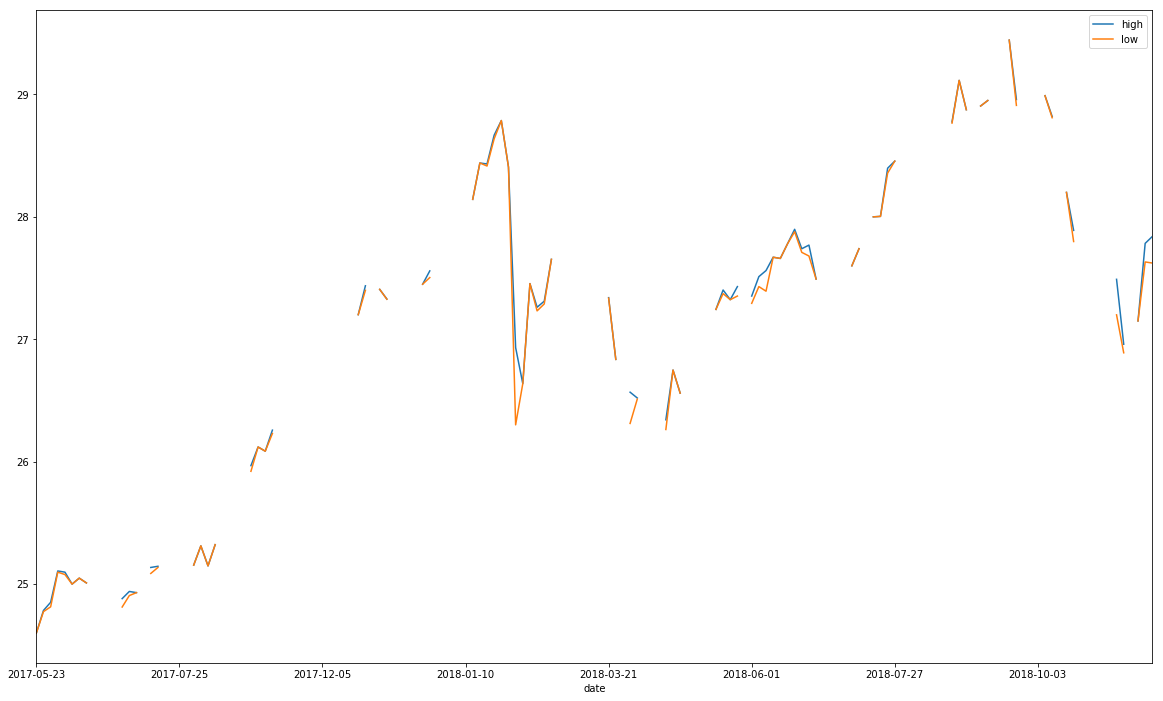

In [18]:
data = df[df.symbol == "YLDE"][["date", "high", "low"]]
data.set_index(['date'], inplace=True)
data.plot(figsize=(20,12))
plt.show()

so let's look at the quantity of missing values per ETF in percentage of data (because all stocks doesn't have everytime the same history

In [19]:
df["missing"] = df.isnull().any(axis=1)
missing_ratio = df.groupby("symbol").agg({"missing": "mean"})
missing_ratio = missing_ratio[missing_ratio["missing"] > 0]

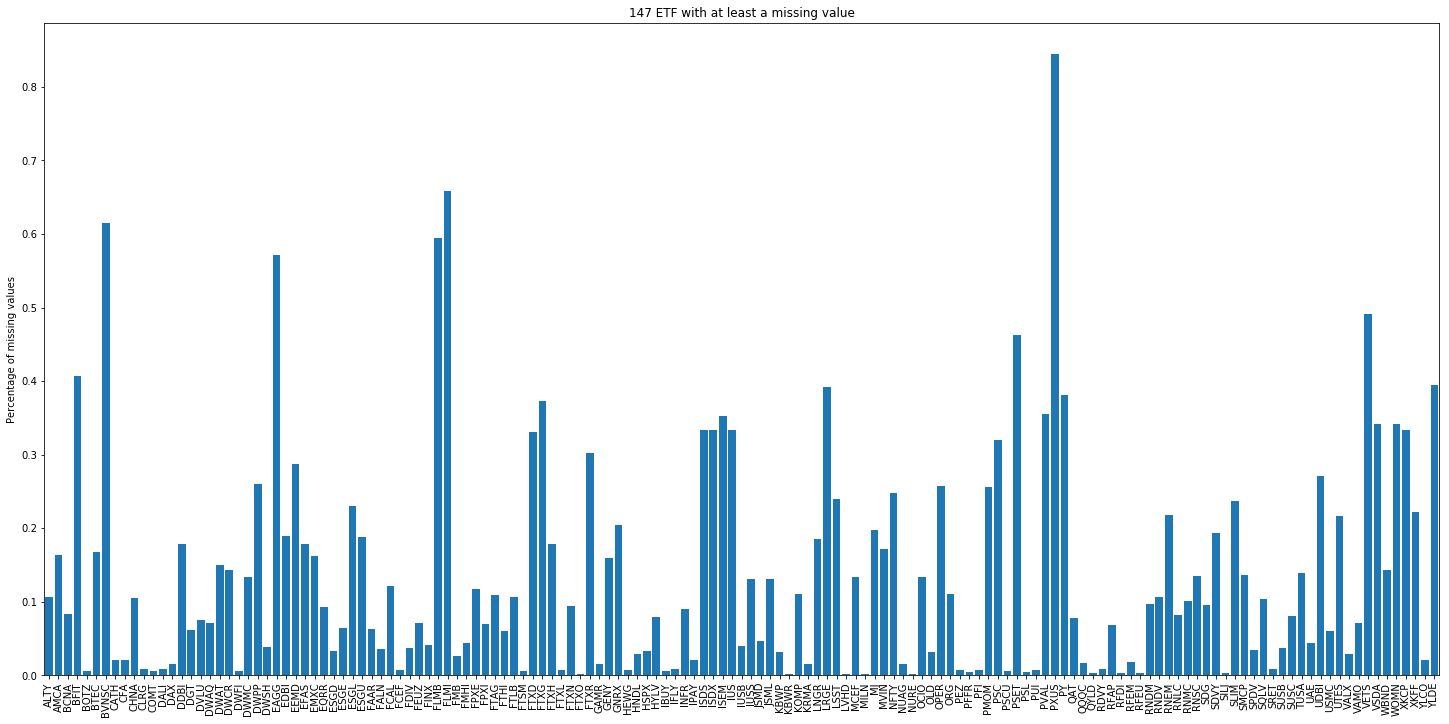

In [21]:
l = len(missing_ratio)
plt.figure(figsize=(25,12))
plt.bar(range(l), missing_ratio["missing"])
plt.xlim(-0.5, l-0.5)
plt.xticks(range(l), missing_ratio.index, rotation='vertical')
plt.title("{} ETF with at least a missing value".format(l))
plt.ylabel("Percentage of missing values")
plt.show()

We can also have a look at the distribution of missing values.

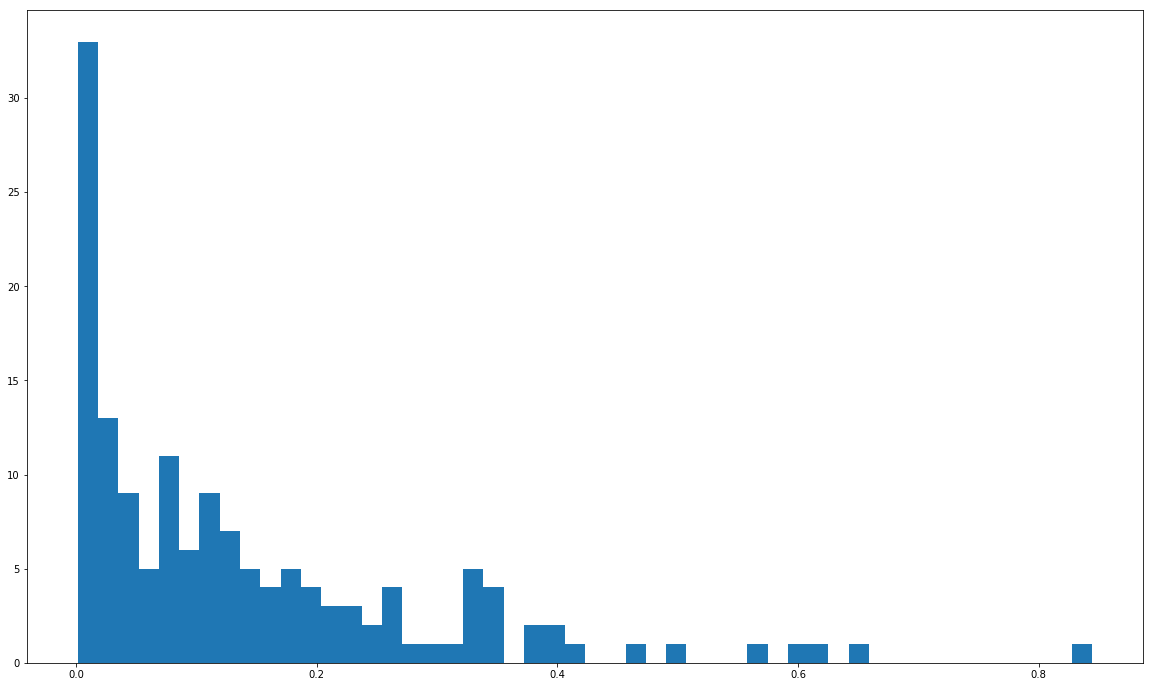

In [22]:
plt.figure(figsize=(20,12))
plt.hist(missing_ratio["missing"], bins=50)
plt.show()

We can see that most of ETFs have only few missing values. What we can do is only remove ETFs with a certain ration of missing values and infer other values

In [23]:
t = 0.15
x = missing_ratio["missing"].values > t
print("With a limit at {}%, we remove {} ETF ({:.2f}% of ETFs with missing values)".format(int(t*100), x.sum(), x.mean()*100))

With a limit at 15%, we remove 50 ETF (34.01% of ETFs with missing values)


In [24]:
index_to_delete = missing_ratio[missing_ratio["missing"] > 0.15].index
index_to_delete

Index(['AMCA', 'BFIT', 'BTEC', 'BVNSC', 'DDBI', 'DWAT', 'DWPP', 'EAGG', 'EDBI',
       'EEMD', 'EFAS', 'EMXC', 'ESGL', 'ESGU', 'FLMB', 'FLMI', 'FTXD', 'FTXG',
       'FTXH', 'FTXR', 'GENY', 'GNRX', 'ISDS', 'ISDX', 'ISEM', 'IUS', 'LNGR',
       'LRGE', 'LSST', 'MJ', 'MVIN', 'NFTY', 'OPER', 'PMOM', 'PSC', 'PSET',
       'PVAL', 'PXUS', 'PY', 'RNEM', 'SDVY', 'SLIM', 'UDBI', 'UTES', 'VETS',
       'VSDA', 'WOMN', 'XKCP', 'XKFF', 'YLDE'],
      dtype='object', name='symbol')

In [25]:
df = df[~df.symbol.isin(index_to_delete)]

### Interpolation

Now we have only etfs with no or few missign values. Let's interpolate values simply by linear regression between 2 known points. This is the result with CHNA which had 10.5% of missing points

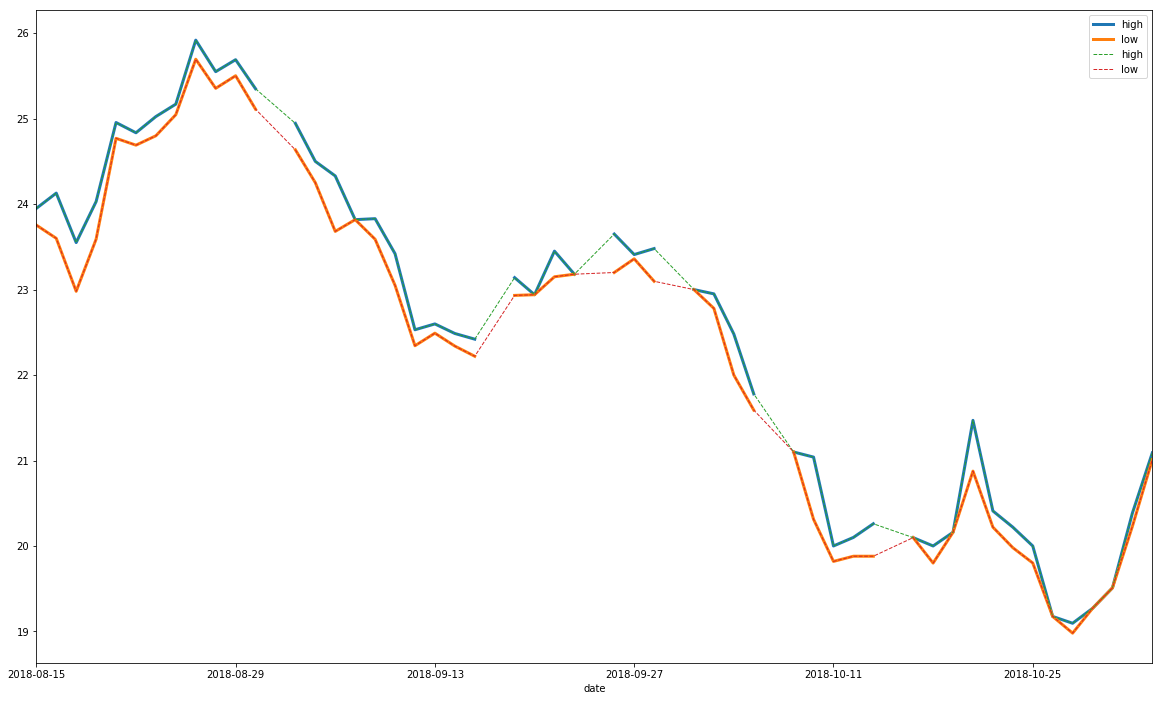

In [26]:
data = df[df.symbol == "CHNA"][["date", "high", "low"]]
data.set_index(['date'], inplace=True)

fig, ax = plt.subplots(figsize=(20,12))
data.plot(ax=ax, linewidth=3)
data.interpolate(method='linear', inplace=True)
data.plot(ax=ax, style="--", linewidth=1)
plt.show()

We have also missing data on opening but not close. We may think that opening price is the same as previous day closing day but it's not the case. So I'll still infer values as I did previously

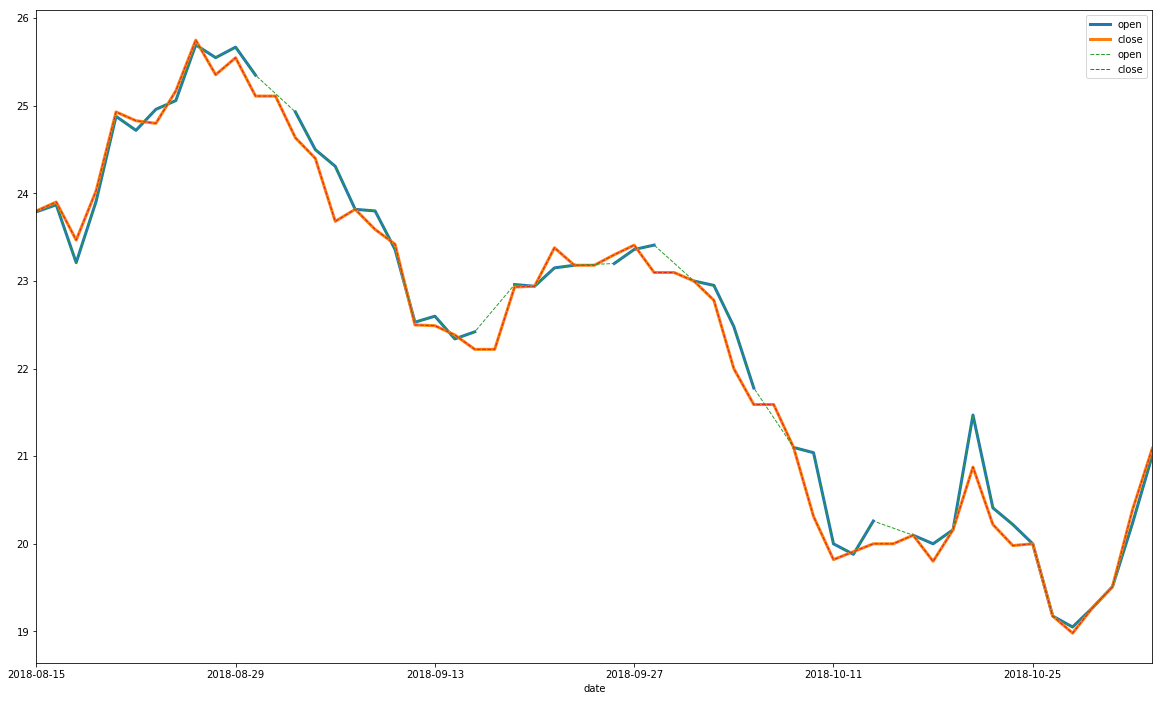

In [27]:
data = df[df.symbol == "CHNA"][["date", "open", "close"]]
data.set_index(['date'], inplace=True)

fig, ax = plt.subplots(figsize=(20,12))
data.plot(ax=ax, linewidth=3)
data.interpolate(method='linear', inplace=True)
data.plot(ax=ax, style="--", linewidth=1)
plt.show()

### Remove ETF with not enough data

We need an history quite important for every ETFs so I'll also remove ETF with not a lot of points. A deeper check will be done a bit later. After that, let's re-create the dataframe

In [29]:
list_df = []
for name in df["symbol"].value_counts().index:
    sub_df = df[df.symbol == name]
    if len(sub_df) < 20: continue
    if sub_df.missing.sum() > 0:
        sub_df.set_index(['date'], inplace=True)
        new_df = sub_df.interpolate(method='linear')
        new_df = new_df.reset_index()
    else:
        new_df = sub_df.copy()
    list_df.append(new_df)

In [30]:
df_filled = pd.concat(list_df)

In [31]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175420 entries, 185172 to 22
Data columns (total 8 columns):
date       175420 non-null object
open       175420 non-null float64
high       175420 non-null float64
low        175420 non-null float64
close      175420 non-null float64
volume     175420 non-null int64
symbol     175420 non-null object
missing    175420 non-null bool
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 10.9+ MB


In [32]:
df_filled.head()

,date,open,high,low,close,volume,symbol,missing
185172,2013-11-04,46.7695,47.1526,46.8755,46.7695,84930,VNQI,False
185173,2013-11-05,46.6716,46.8127,46.5736,46.6471,57853,VNQI,False
185174,2013-11-06,46.5573,46.9163,46.6552,46.5328,84803,VNQI,False
185175,2013-11-07,46.2554,46.7042,46.0351,46.3778,93642,VNQI,False
185176,2013-11-08,46.0025,46.2881,45.9047,45.9535,78088,VNQI,False


In [33]:
df_filled = df_filled.reset_index(drop=True)
df_filled.drop("missing", inplace=True, axis=1)
df_filled.to_csv("F:/data/trading/history_imputed.csv")

So at this point, we only lost 17 000 rows but provides a nice cleanup. Let's now continue with recency by ETF

### Recency

In [4]:
df = pd.read_csv("F:/data/trading/history_imputed.csv", index_col=0)

df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df.head()

,date,open,high,low,close,volume,symbol
0,2013-11-04,46.7695,47.1526,46.8755,46.7695,84930,VNQI
1,2013-11-05,46.6716,46.8127,46.5736,46.6471,57853,VNQI
2,2013-11-06,46.5573,46.9163,46.6552,46.5328,84803,VNQI
3,2013-11-07,46.2554,46.7042,46.0351,46.3778,93642,VNQI
4,2013-11-08,46.0025,46.2881,45.9047,45.9535,78088,VNQI


In [5]:
df["count"] = 1
recency = df.groupby("symbol").agg({
    "date" : [np.min, np.max],
    "count" : sum
})

In [6]:
recency["recency"] = recency[("date", "amax")] - recency[("date", "amin")]

In [7]:
recency.head()

date            count   recency
             amin       amax   sum          
symbol                                      
ACT    2017-12-13 2018-11-02   225  324 days
AIA    2013-11-04 2018-11-02  1260 1824 days
AIQ    2018-05-16 2018-11-02   120  170 days
ALTY   2015-07-14 2018-11-02   822 1207 days
BBH    2013-11-04 2018-11-02  1260 1824 days

In [8]:
recency["recency"] = recency["recency"].apply(lambda x:x.days)
recency["freq"] = recency[("count", "sum")] / recency[("recency", )]

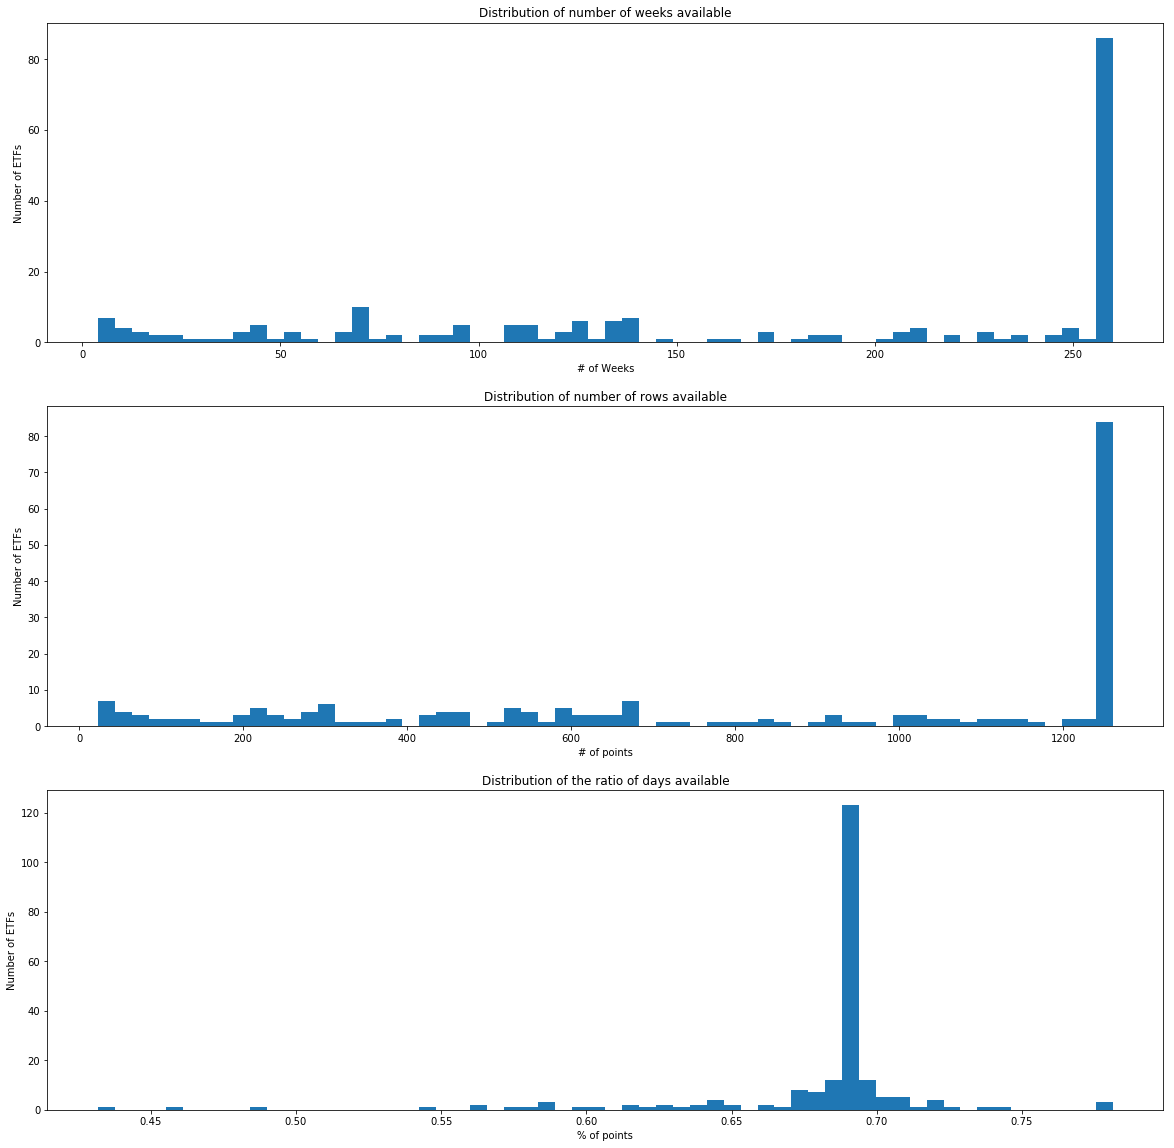

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(20, 20))
axes[0].hist(recency[("recency", )]//7, bins=5*12)
axes[0].set_title("Distribution of number of weeks available")
axes[0].set_xlabel("# of Weeks")
axes[0].set_ylabel("Number of ETFs")
axes[1].hist(recency[("count", "sum")], bins=5*12)
axes[1].set_title("Distribution of number of rows available")
axes[1].set_xlabel("# of points")
axes[1].set_ylabel("Number of ETFs")
axes[2].hist(recency[("freq")], bins=5*12)
axes[2].set_title("Distribution of the ratio of days available")
axes[2].set_xlabel("% of points")
axes[2].set_ylabel("Number of ETFs")
plt.show()

Now based on number of points available and history, we can continue to filter a bit the ETFs

In [79]:
t = 365
x = recency[("recency", )].values < t
print("With a limit at {}days, we remove {} ETF ({:.2f}% of ETFs)".format(t, x.sum(), x.mean()*100))

With a limit at 365days, we remove 32 ETF (15.02% of ETFs)


In [80]:
t = 0.66
x = recency["freq"].values < t
print("With a limit of density of {}%, we remove {} ETF ({:.2f}% of ETFs)".format(int(t*100), x.sum(), x.mean()*100))

With a limit of density of 66%, we remove 28 ETF (13.15% of ETFs)


In [81]:
index_to_delete_age = recency[recency[("recency", )] < 365].index
index_to_delete_freq = recency[recency["freq"].values < t].index

In [82]:
index_to_delete = np.union1d(index_to_delete_age, index_to_delete_freq)

In [89]:
index_to_delete

array(['ACT', 'AIQ', 'BCNA', 'BJUL', 'BLCN', 'BNDW', 'BOCT', 'CFA',
       'CHNA', 'CLRG', 'DALI', 'DDIV', 'DINT', 'DRIV', 'DTEC', 'DVLU',
       'DWCR', 'DWMC', 'DWSH', 'EASI', 'EQRR', 'ESGD', 'FAAR', 'FCAL',
       'FEUZ', 'FMHI', 'FPXI', 'FTHI', 'FTLB', 'FTXN', 'HNDL', 'INFR',
       'IUSS', 'KNG', 'LDRS', 'MCEF', 'OCIO', 'PJUL', 'POCT', 'QAT',
       'RFAP', 'RNDM', 'RNDV', 'RNLC', 'RNMC', 'RNSC', 'SMCP', 'SPDV',
       'SQLV', 'SUSB', 'SUSC', 'TMFC', 'TUSA', 'UJUL', 'UOCT', 'USIG',
       'VTC'], dtype=object)

In [90]:
df = df[~df.symbol.isin(index_to_delete)]
df = df.reset_index(drop=True)
df.to_csv("F:/data/trading/history_imputed_1y.csv")

That's it for now. We can save this clean dataset and start to pre-process the data.

### Data Availability for model

In order to avoid to important variation based on the date for the momentum trading, we will merge data by week. For each features, we can compute the min, max and average. For the volume, the sum will be also computed as it's more logical.

In [15]:
from datetime import datetime

In [16]:
df = pd.read_csv("F:/data/trading/history_imputed_1y.csv", index_col=0)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157326 entries, 0 to 157325
Data columns (total 7 columns):
date      157326 non-null datetime64[ns]
open      157326 non-null float64
high      157326 non-null float64
low       157326 non-null float64
close     157326 non-null float64
volume    157326 non-null int64
symbol    157326 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 9.6+ MB


In [18]:
df.head()

,date,open,high,low,close,volume,symbol
0,2013-11-04,46.7695,47.1526,46.8755,46.7695,84930,VNQI
1,2013-11-05,46.6716,46.8127,46.5736,46.6471,57853,VNQI
2,2013-11-06,46.5573,46.9163,46.6552,46.5328,84803,VNQI
3,2013-11-07,46.2554,46.7042,46.0351,46.3778,93642,VNQI
4,2013-11-08,46.0025,46.2881,45.9047,45.9535,78088,VNQI


In [19]:
df = df.groupby(["symbol", pd.Grouper(key='date', freq='W-MON')]).agg({
    "open" : ["min", "max", "mean"],
    "close" : ["min", "max", "mean"],
    "low" : ["min", "max", "mean"],
    "high" : ["min", "max", "mean"],
    "volume" : ["min", "max", "mean", "sum"],
})
df.to_csv("F:/data/trading/stat_history.csv")

In [20]:
df.head()

open                       close                      \
                       min      max      mean      min      max       mean   
symbol date                                                                  
AIA    2013-11-04  43.3307  43.3307  43.33070  43.5742  43.5742  43.574200   
       2013-11-11  42.3476  43.1052  42.87070  42.5550  43.1593  42.836240   
       2013-11-18  42.0103  44.3499  42.87540  42.2844  44.1425  43.009180   
       2013-11-25  43.5923  44.4131  44.02704  43.5742  44.2507  43.906160   
       2013-12-02  43.7186  44.4221  44.12220  43.9080  44.4582  44.183075   

                       low                         high                     \
                       min      max       mean      min      max      mean   
symbol date                                                                  
AIA    2013-11-04  43.3307  43.3307  43.330700  43.6103  43.6103  43.61030   
       2013-11-11  42.2844  43.0884  42.694160  42.7345  43.2567  43.04332   
       2013-11-18  42.0083  44.0162  42.779400  42.2934  44.4023  43.13348   
       2013-11-25  43.5292  44.2417  43.760060  43.8178  44.4293  44.12590   
       2013-12-02  43.7186  44.3418  44.029975  43.9711  44.5123  44.30710   

                  volume                           
                     min    max      mean     sum  
symbol date                                        
AIA    2013-11-04  12326  12326  12326.00   12326  
       2013-11-11  12168  35407  23328.40  116642  
       2013-11-18   3991  47895  21017.20  105086  
       2013-11-25   6599  37123  23889.40  119447  
       2013-12-02   6229  18233  11868.75   47475

Thansk to this merge, we should also have no missing point in every weeks. We can now show the history by ETF

In [10]:
df2 = pd.DataFrame(index=df.index)
df2 = df2.reset_index()
df2["date"] = pd.to_datetime(df2["date"], format="%Y-%m-%d")

In [11]:
names = np.unique(df2.symbol.values).tolist()

In [12]:
def to_weeks(date):
    now = datetime(2018, 11, 2)
    delay = date-now
    return delay.days//7

df2["x"] = df2["date"].apply(lambda x: to_weeks(x))
df2["y"] = df2["symbol"].apply(lambda x:names.index(x))

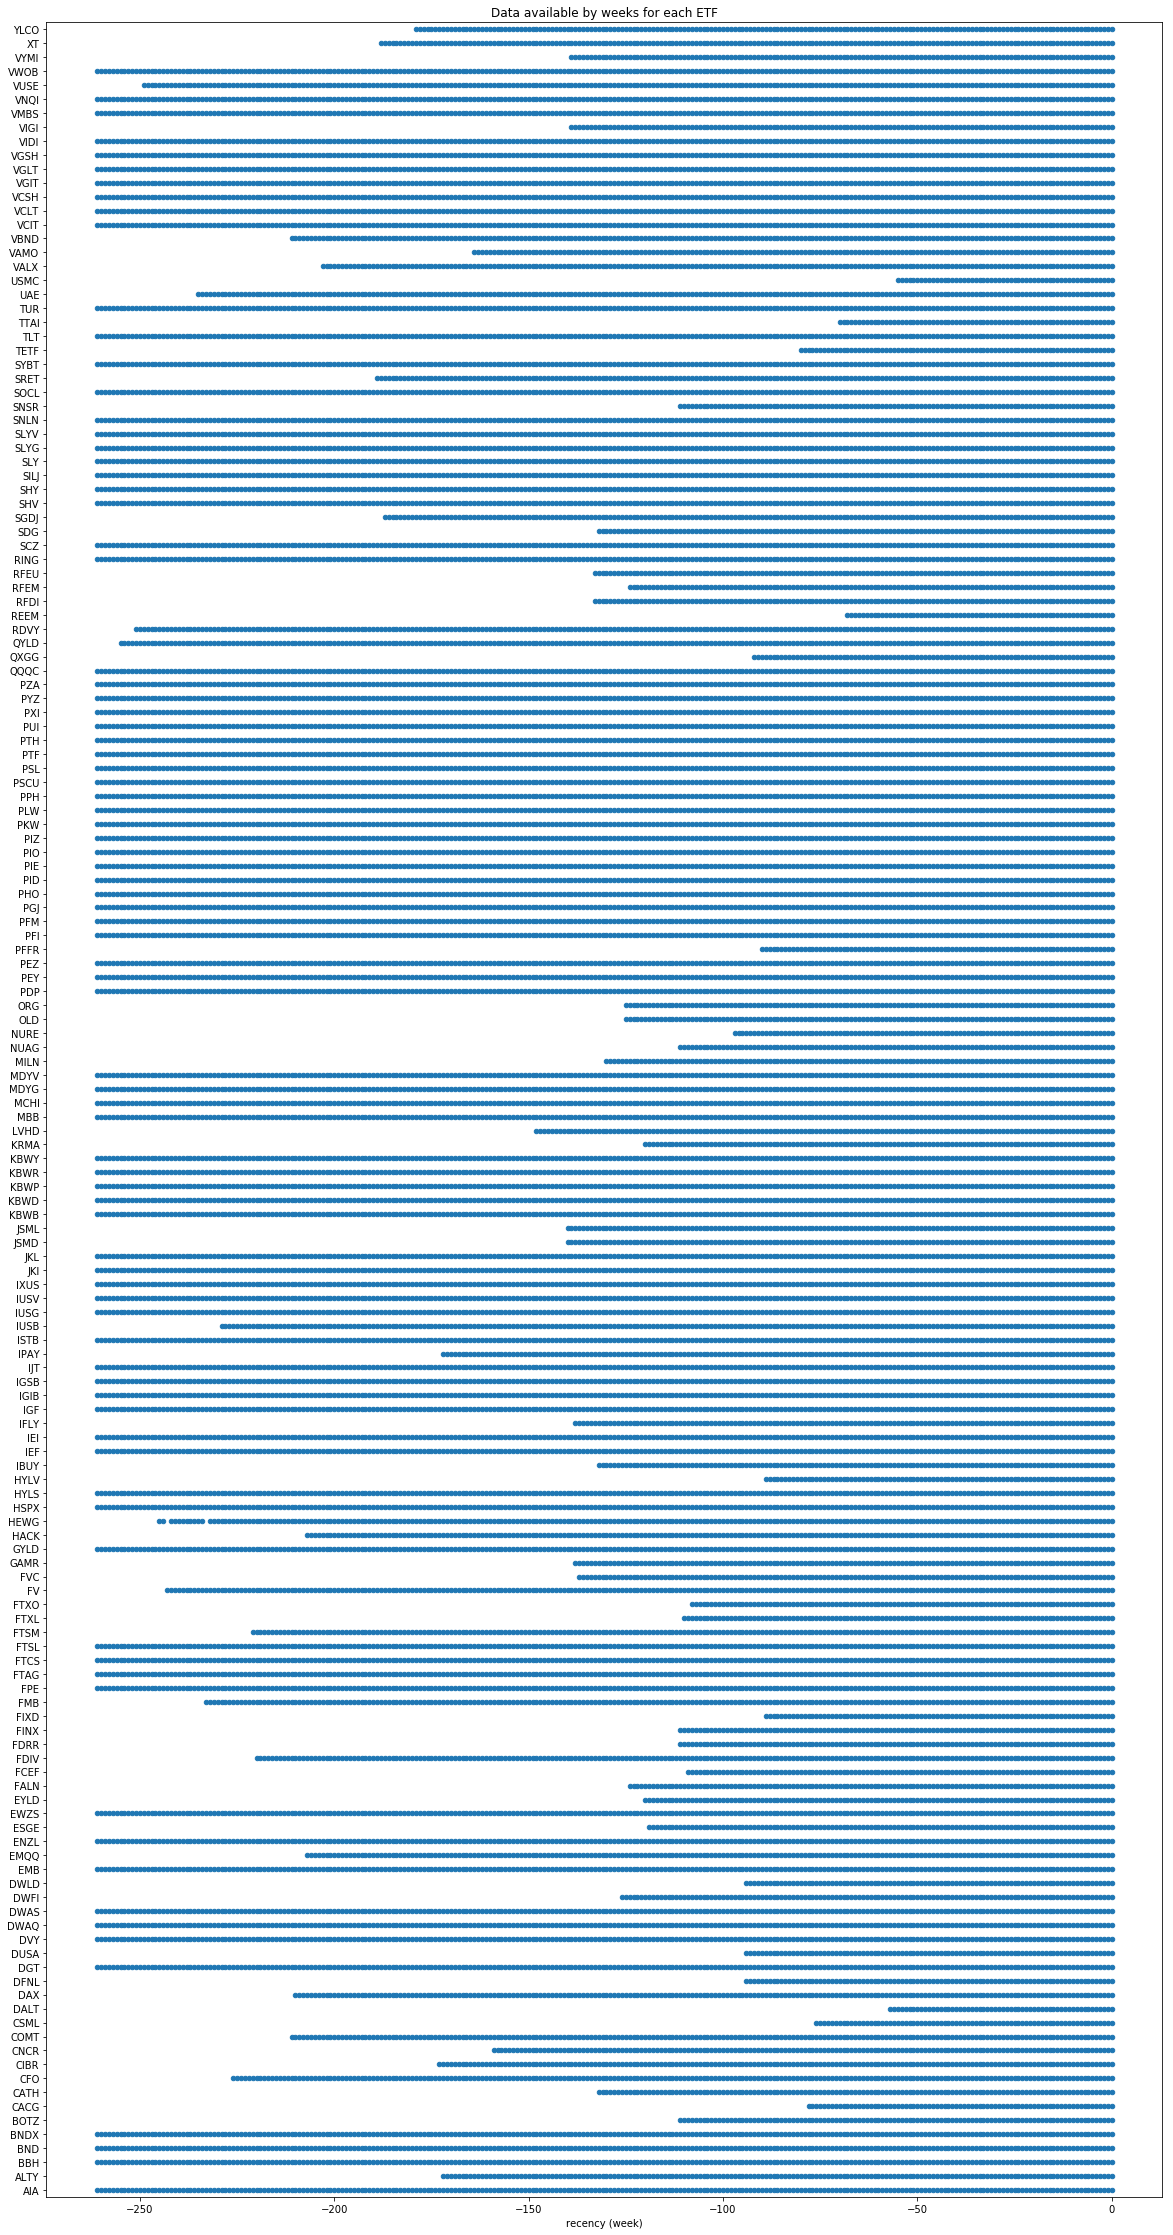

In [13]:
fig, ax = plt.subplots(figsize=(20, 40))
df2.plot.scatter("x", "y", ax=ax)
plt.ylim(-0.5, len(names)-0.5)
ax.set_yticks(ticks=range(len(names)))
ax.set_yticklabels(names)
ax.set_ylabel("")
ax.set_xlabel("recency (week)")
ax.set_title("Data available by weeks for each ETF")
# plt.savefig("availability.png")
plt.show()

We have several ETF with 5 years of data bu few of them have just a year (as we filtered it previously). We can no save this dataframe for the Momentum trading model. But this one won't be used as is. We need to have performances for each ETFs. This is what we will do now

# Create Perf Dataframe

We now have several stats regarding each ETFs but they don't have all the same initial price and we need a features to compute the value of a dataframe. To do so, I decided to take :

\begin{equation*}
Value_{week} = \frac{1}{N}\sum_{day = 0}^{N}\frac{Low_{day} + High_{day}}{2}
\end{equation*}

whihc can be shown as :

<img src="Perf_value.png"/>

So let's now stat to compute the value for each ETFs and each week

In [22]:
df = pd.read_csv("F:/data/trading/stat_history.csv", header =[0, 1], index_col=[0, 1])

In [23]:
df.head()

open                       close                      \
                       min      max      mean      min      max       mean   
symbol date                                                                  
AIA    2013-11-04  43.3307  43.3307  43.33070  43.5742  43.5742  43.574200   
       2013-11-11  42.3476  43.1052  42.87070  42.5550  43.1593  42.836240   
       2013-11-18  42.0103  44.3499  42.87540  42.2844  44.1425  43.009180   
       2013-11-25  43.5923  44.4131  44.02704  43.5742  44.2507  43.906160   
       2013-12-02  43.7186  44.4221  44.12220  43.9080  44.4582  44.183075   

                       low                         high                     \
                       min      max       mean      min      max      mean   
symbol date                                                                  
AIA    2013-11-04  43.3307  43.3307  43.330700  43.6103  43.6103  43.61030   
       2013-11-11  42.2844  43.0884  42.694160  42.7345  43.2567  43.04332   
       2013-11-18  42.0083  44.0162  42.779400  42.2934  44.4023  43.13348   
       2013-11-25  43.5292  44.2417  43.760060  43.8178  44.4293  44.12590   
       2013-12-02  43.7186  44.3418  44.029975  43.9711  44.5123  44.30710   

                  volume                           
                     min    max      mean     sum  
symbol date                                        
AIA    2013-11-04  12326  12326  12326.00   12326  
       2013-11-11  12168  35407  23328.40  116642  
       2013-11-18   3991  47895  21017.20  105086  
       2013-11-25   6599  37123  23889.40  119447  
       2013-12-02   6229  18233  11868.75   47475

In [24]:
from datetime import datetime

def to_weeks(date):
    now = datetime(2018, 11, 2)
    delay = date-now
    return delay.days//7

df = df.reset_index()
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["weeks"] = df["date"].apply(lambda x: to_weeks(x))
df.head()

symbol       date     open                       close                      \
                         min      max      mean      min      max       mean   
0    AIA 2013-11-04  43.3307  43.3307  43.33070  43.5742  43.5742  43.574200   
1    AIA 2013-11-11  42.3476  43.1052  42.87070  42.5550  43.1593  42.836240   
2    AIA 2013-11-18  42.0103  44.3499  42.87540  42.2844  44.1425  43.009180   
3    AIA 2013-11-25  43.5923  44.4131  44.02704  43.5742  44.2507  43.906160   
4    AIA 2013-12-02  43.7186  44.4221  44.12220  43.9080  44.4582  44.183075   

       low                         high                    volume         \
       min      max       mean      min      max      mean    min    max   
0  43.3307  43.3307  43.330700  43.6103  43.6103  43.61030  12326  12326   
1  42.2844  43.0884  42.694160  42.7345  43.2567  43.04332  12168  35407   
2  42.0083  44.0162  42.779400  42.2934  44.4023  43.13348   3991  47895   
3  43.5292  44.2417  43.760060  43.8178  44.4293  44.12590   6599  37123   
4  43.7186  44.3418  44.029975  43.9711  44.5123  44.30710   6229  18233   

                    weeks  
       mean     sum        
0  12326.00   12326  -261  
1  23328.40  116642  -260  
2  21017.20  105086  -259  
3  23889.40  119447  -258  
4  11868.75   47475  -257

In [25]:
df["value"] = (df[("low", "mean")] + df[("high", "mean")])/2

That's it. We can now plot the performance along time for each Symbol

In [26]:
df = df.pivot(index='date', columns='symbol', values="value")

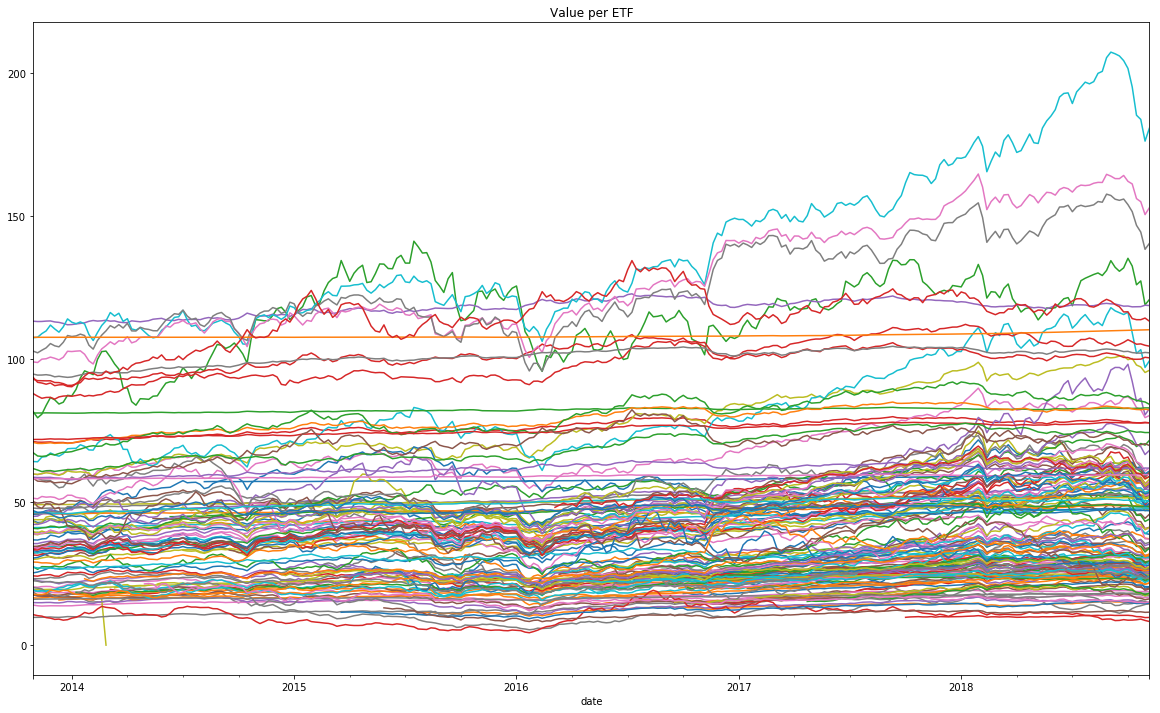

In [27]:
fig, ax = plt.subplots(figsize=(20,12))
df.plot(ax=ax, legend=False)
ax.set_title("Value per ETF")
plt.show()

In [46]:
df.head()

symbol,AIA,ALTY,BBH,BND,BNDX,BOTZ,CACG,CATH,CFO,CIBR,...,VGSH,VIDI,VIGI,VMBS,VNQI,VUSE,VWOB,VYMI,XT,YLCO
date,,,,,,,,,,,,,,,,,,,,,
2013-11-04,43.470500,NaN,81.559250,71.182500,46.03705,NaN,NaN,NaN,NaN,NaN,...,58.170550,22.510550,NaN,46.48185,47.01405,NaN,61.707950,NaN,NaN,NaN
2013-11-11,42.868740,NaN,79.486980,70.964220,45.93782,NaN,NaN,NaN,NaN,NaN,...,58.168730,22.341500,NaN,46.34703,46.41641,NaN,61.224230,NaN,NaN,NaN
2013-11-18,42.956440,NaN,80.753670,70.942620,45.93761,NaN,NaN,NaN,NaN,NaN,...,58.189630,21.966720,NaN,46.33793,46.49851,NaN,60.675180,NaN,NaN,NaN
2013-11-25,43.942980,NaN,83.821820,70.998240,45.93585,NaN,NaN,NaN,NaN,NaN,...,58.217680,22.189570,NaN,46.39716,46.24886,NaN,60.972490,NaN,NaN,NaN
2013-12-02,44.168537,NaN,86.550112,71.045488,45.99070,NaN,NaN,NaN,NaN,NaN,...,58.205862,22.245533,NaN,46.24375,45.86225,NaN,61.023337,NaN,NaN,NaN


The probelem here is that prices are not the same. to have a real performance indicator, we need to normalize each ETF by dividing them by their first value

In [28]:
def normalize(x):
    x0 = x[x.first_valid_index()]
    return x/x0

df = df.apply(lambda x: normalize(x), axis=0)

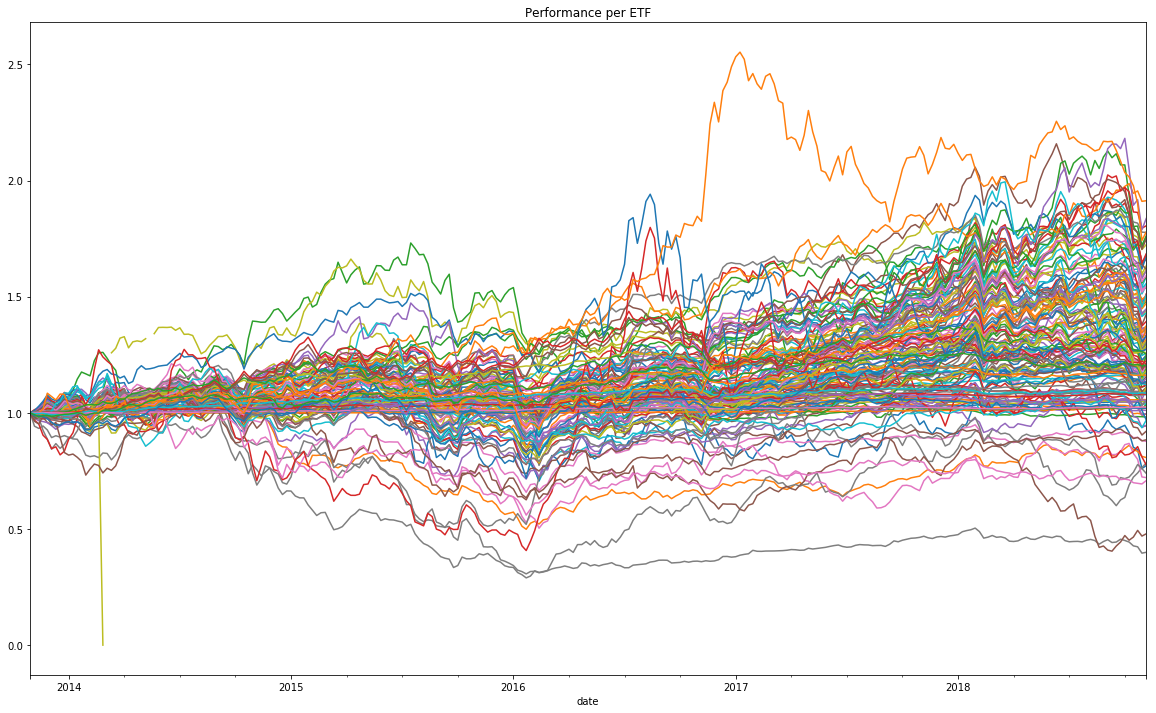

In [29]:
fig, ax = plt.subplots(figsize=(20,12))
df.plot(ax=ax, legend=False)
ax.set_title("Performance per ETF")
plt.show()

Now we really have a performance indicator

In [56]:
df.to_csv("F:/data/trading/perfs.csv")

# Ranking ETF

One last thing we can do is to "sort" ETF just for indication. First we can sort them by median performance (I don't use the mean beacuse a huge peak may impact a lot the general performance of the ETF.

The second one can be by fluctuation around their median value. 

In [30]:
df = pd.read_csv("F:/data/trading/perfs.csv", index_col = 0)
df.head()

,AIA,ALTY,BBH,BND,BNDX,BOTZ,CACG,CATH,CFO,CIBR,...,VGSH,VIDI,VIGI,VMBS,VNQI,VUSE,VWOB,VYMI,XT,YLCO
date,,,,,,,,,,,,,,,,,,,,,
2013-11-04,1.000000,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,NaN,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN
2013-11-11,0.986157,NaN,0.974592,0.996934,0.997845,NaN,NaN,NaN,NaN,NaN,...,0.999969,0.992490,NaN,0.997100,0.987288,NaN,0.992161,NaN,NaN,NaN
2013-11-18,0.988175,NaN,0.990123,0.996630,0.997840,NaN,NaN,NaN,NaN,NaN,...,1.000328,0.975841,NaN,0.996904,0.989034,NaN,0.983264,NaN,NaN,NaN
2013-11-25,1.010869,NaN,1.027741,0.997411,0.997802,NaN,NaN,NaN,NaN,NaN,...,1.000810,0.985741,NaN,0.998178,0.983724,NaN,0.988082,NaN,NaN,NaN
2013-12-02,1.016058,NaN,1.061193,0.998075,0.998993,NaN,NaN,NaN,NaN,NaN,...,1.000607,0.988227,NaN,0.994878,0.975501,NaN,0.988906,NaN,NaN,NaN


In [41]:
Y = []
meds = []
devs = []
for name in df:
    X = df[name] / df[name].shift(1)
    X = X.dropna()
    X = (X-1)*100
    X = X[np.abs(X) < 50]
    meds.append(X.median())
    devs.append(X.std())
    Y.append(X.values)

In [46]:
Y = np.array(Y)
X = df.columns
order = np.argsort(meds)
order2 = np.argsort(devs)[::-1]
Y1 = Y[order]
X1 = X[order]
Y2 = Y[order2]
X2 = X[order2]

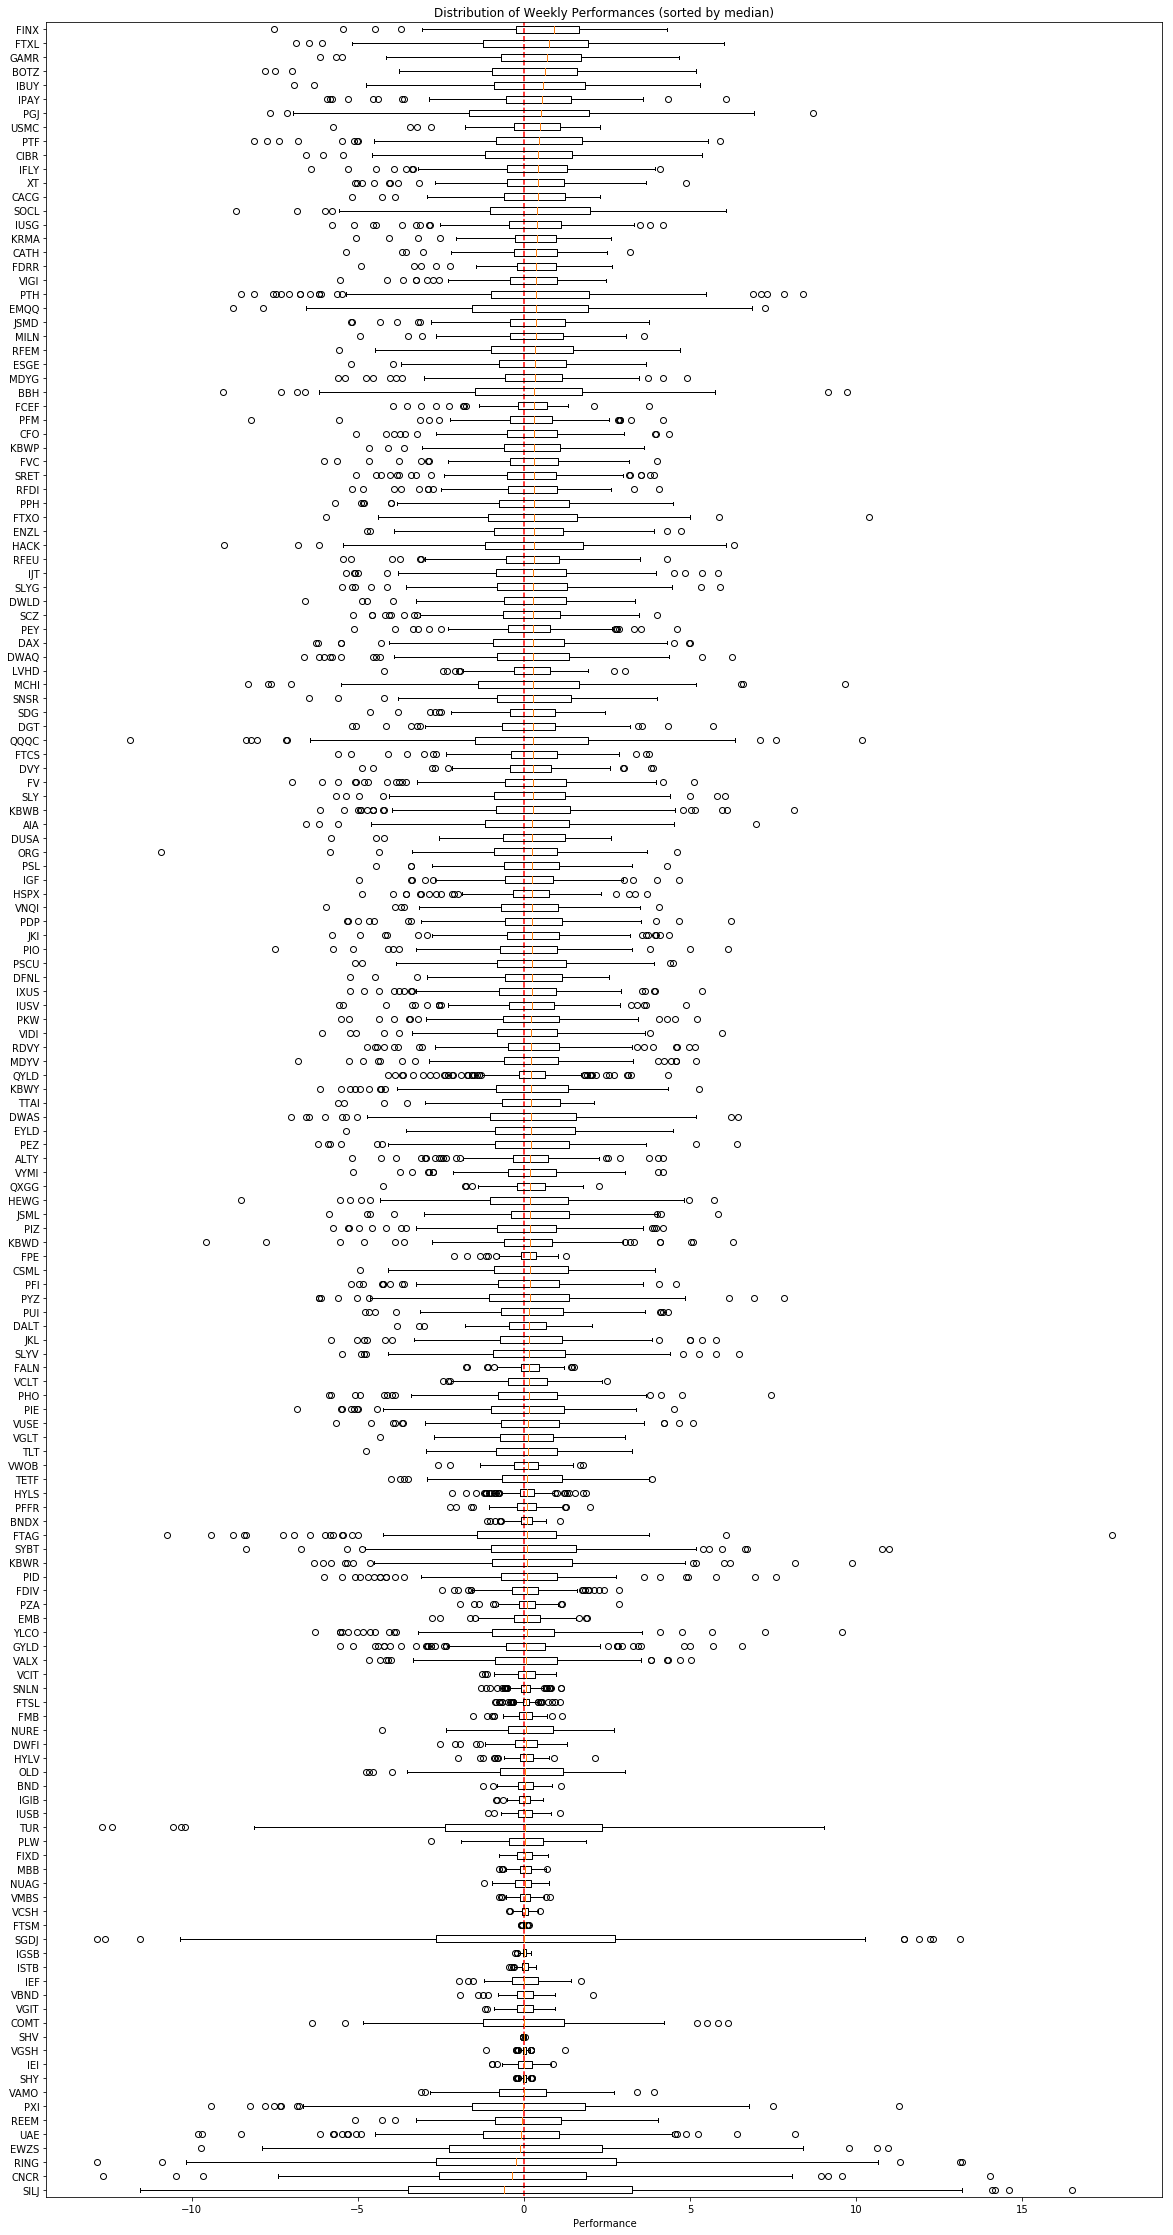

In [44]:
plt.figure(figsize=(20,40))    
plt.boxplot(Y1, vert=False, labels = X1)
plt.vlines(0, 0, len(X1)+0.5, colors ="r", linestyles ="dashed")
plt.title("Distribution of Weekly Performances (sorted by median)")
plt.xlabel("Performance")
# plt.savefig("perfs_median.png", dpi=250)
plt.show()

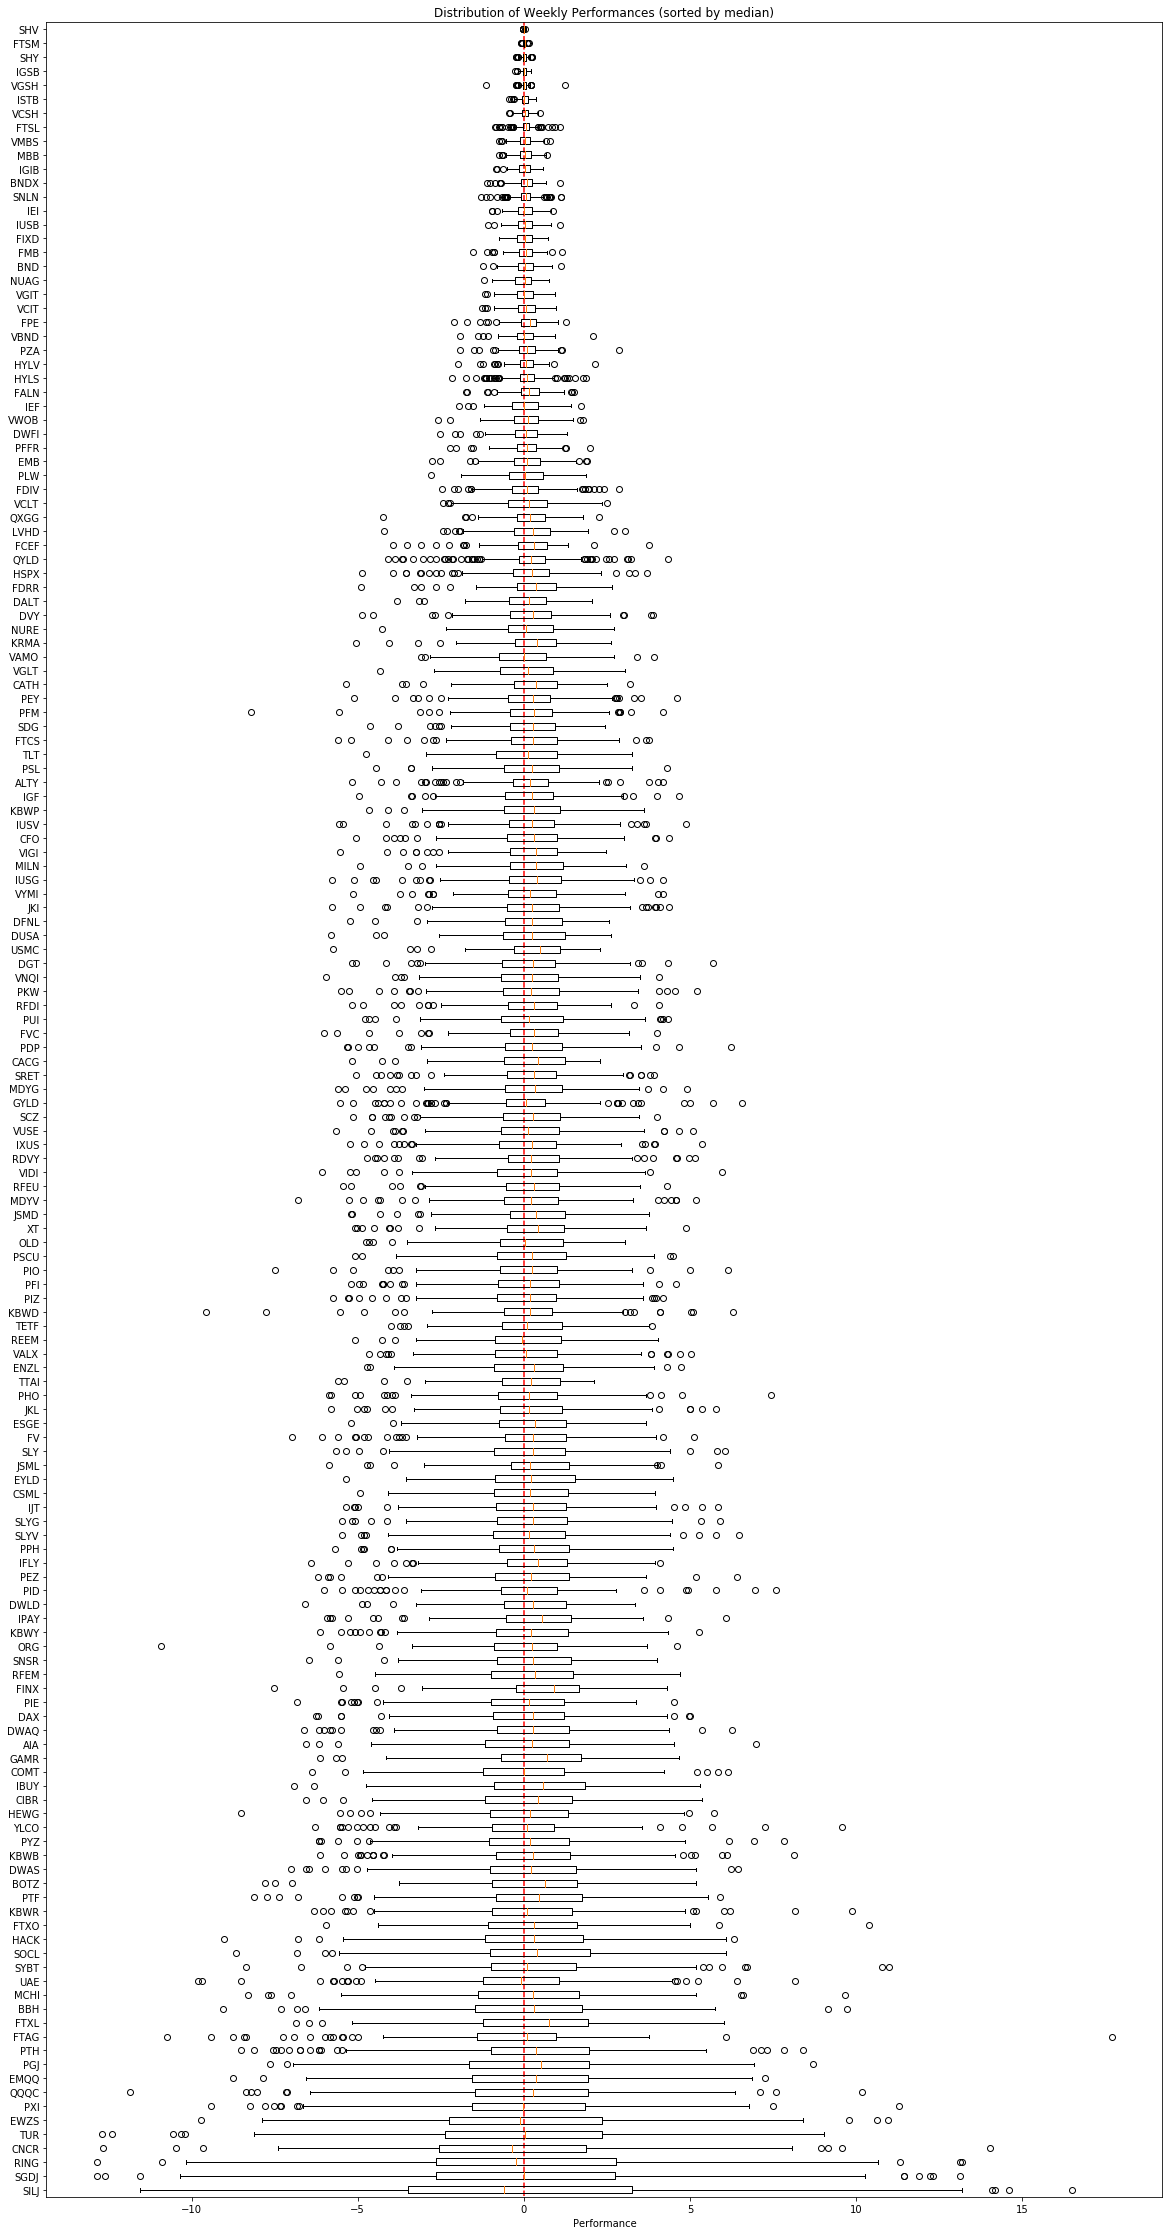

In [47]:
plt.figure(figsize=(20,40))    
plt.boxplot(Y2, vert=False, labels = X2)
plt.vlines(0, 0, len(X2)+0.5, colors ="r", linestyles ="dashed")
plt.title("Distribution of Weekly Performances (sorted by median)")
plt.xlabel("Performance")
# plt.savefig("perfs_dev.png", dpi=250)
plt.show()

This is only an indication but we can see that for example SILJ is really a bad ETF as it has the hishgest volatility and a negative performance. In the other hand, FINX is still with volatility but has a monthy performance median at around 2%.

In [49]:
gc.collect()

181994

# Conclusion

In this first Notebook, we retreive datas and pre-process them to have a performance indicator for a simulation afterward. Next week, a simple model will be proposed to check if the momentum trading worth it.